In [10]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [11]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import pandas as pd
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold

In [12]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [13]:
data_flag = 'bloodmnist'
download = True

BATCH_SIZE = 128


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Read the MedMNIST data, preprocess and encapsulate into dataloader form

In [14]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\anany\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\anany\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\anany\.medmnist\bloodmnist.npz


In [15]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\anany\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 

In [16]:
# visualization

train_dataset.montage(length=1)

C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


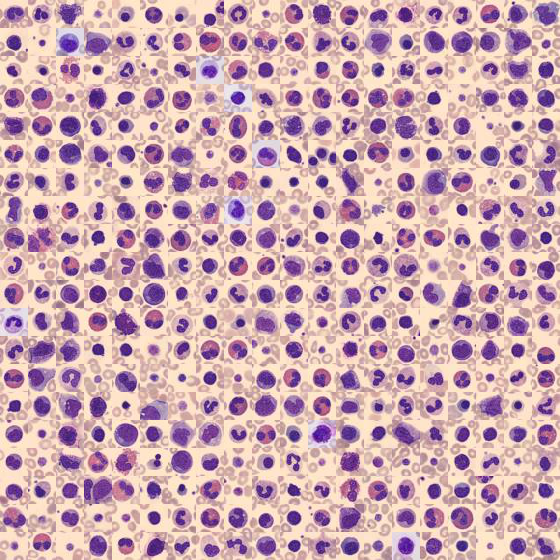

In [17]:
# visualization

train_dataset.montage(length=20)

In [18]:
train_dataset

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\anany\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 

In [19]:
train_dataset.info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

In [20]:
train_dataset.imgs.shape

(11959, 28, 28, 3)

In [21]:
train_dataset.labels.shape

(11959, 1)

In [22]:
list(train_dataset.info.keys())

['python_class',
 'description',
 'url',
 'MD5',
 'task',
 'label',
 'n_channels',
 'n_samples',
 'license']

In [23]:
x_train = np.array([x.flatten() for x in train_dataset.imgs])
y_train=train_dataset.labels

In [24]:
x_train.shape

(11959, 2352)

In [25]:
pd.DataFrame(x_train).describe()

0             1             2             3             4     \
count  11959.000000  11959.000000  11959.000000  11959.000000  11959.000000   
mean     230.259470    199.466260    185.771971    230.241074    199.407141   
std       25.281879     29.743451     23.421677     24.729891     29.178996   
min       62.000000     21.000000     69.000000     63.000000     21.000000   
25%      209.000000    174.000000    169.000000    210.000000    175.000000   
50%      238.000000    207.000000    189.000000    236.000000    205.000000   
75%      254.000000    226.000000    203.000000    254.000000    227.000000   
max      255.000000    248.000000    255.000000    255.000000    247.000000   

               5             6             7             8             9     \
count  11959.000000  11959.000000  11959.000000  11959.000000  11959.000000   
mean     185.817209    230.114725    199.522786    186.051342    230.391588   
std       21.289156     25.195918     29.400118     21.468123     25.265357   
min       71.000000     67.000000     29.000000     76.000000     67.000000   
25%      169.000000    210.000000    175.000000    168.000000    210.000000   
50%      188.000000    237.000000    206.000000    191.000000    238.000000   
75%      202.000000    254.000000    227.000000    203.000000    254.000000   
max      255.000000    255.000000    249.000000    253.000000    255.000000   

       ...          2342          2343          2344          2345  \
count  ...  11959.000000  11959.000000  11959.000000  11959.000000   
mean   ...    183.754913    227.485074    196.210051    184.081612   
std    ...     21.270030     25.509692     29.109864     20.200137   
min    ...     99.000000     70.000000     31.000000    101.000000   
25%    ...    165.000000    207.000000    173.000000    167.000000   
50%    ...    189.000000    230.000000    199.000000    188.000000   
75%    ...    201.000000    253.000000    225.000000    201.000000   
max    ...    246.000000    255.000000    243.000000    242.000000   

               2346          2347          2348          2349          2350  \
count  11959.000000  11959.000000  11959.000000  11959.000000  11959.000000   
mean     227.737269    196.184714    184.630487    228.022661    196.364328   
std       25.276727     29.226230     19.674369     25.605040     29.794602   
min       67.000000     26.000000     96.000000     69.000000     23.000000   
25%      207.000000    172.000000    168.000000    207.000000    171.000000   
50%      231.000000    199.000000    188.000000    232.000000    200.000000   
75%      253.000000    225.000000    201.000000    253.000000    225.000000   
max      255.000000    244.000000    243.000000    255.000000    236.000000   

               2351  
count  11959.000000  
mean     185.049921  
std       19.895065  
min      107.000000  
25%      168.000000  
50%      189.000000  
75%      202.000000  
max      243.000000  

[8 rows x 2352 columns]

### Class Imbalance

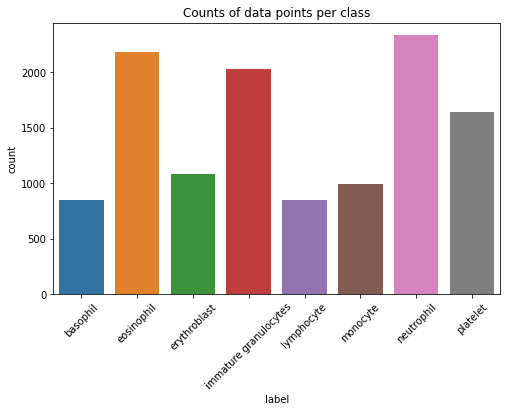

In [26]:
plt.figure(figsize=(8,5))
plt.title('Counts of data points per class')
y_train=pd.DataFrame(y_train)
label_map = train_dataset.info['label']
sns.countplot(x = y_train.iloc[:, 0])
old_xaxis = [int(x) for x in list(label_map.keys())]
new_axis = list(label_map.values())
new_axis[3] = 'immature granulocytes'
plt.xticks(old_xaxis, new_axis, rotation=45)
plt.xlabel('label')
plt.show()

### t-SNE

In [17]:
tsne = manifold.TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.025s...
[t-SNE] Computed neighbors for 11959 samples in 12.910s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 385.645257
[t-SNE] KL diverge

In [18]:
x_train=pd.DataFrame(x_train)
y_train=np.array(y_train)

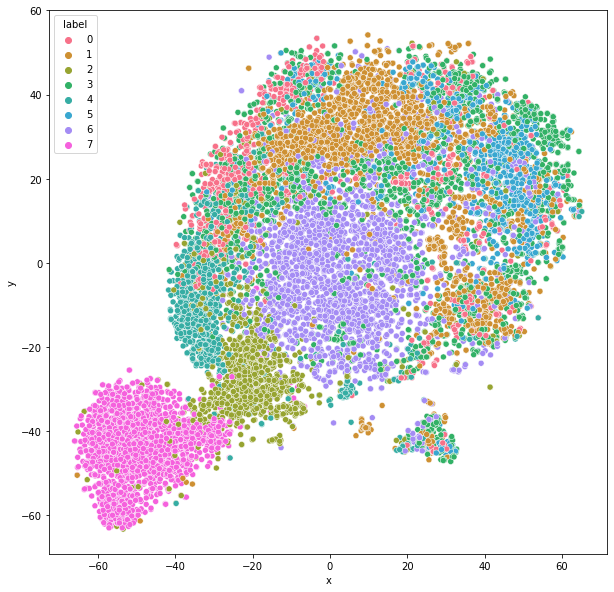

In [19]:
df_tsne= pd.DataFrame(columns = ["x", "y", "label"] )
df_tsne["x"] = tsne[:,0]
df_tsne["y"] = tsne[:,1]
df_tsne["label"] = y_train

plt.figure(figsize = (10,10))
sns.scatterplot(x = df_tsne["x"], y = df_tsne["y"], hue = df_tsne["label"],  palette = sns.color_palette("husl",8))
plt.show()

### PCA

In [20]:
x_train=pd.DataFrame(x_train)
y_train=pd.DataFrame(y_train)

In [21]:
from sklearn.decomposition import PCA

feature_selector = PCA(120, random_state=0)
x_train = feature_selector.fit_transform(x_train)

pca_plot_df = pd.DataFrame(data=x_train[:,0:2], columns=['PC 1', 'PC 2'])
pca_plot_df = pd.concat([pca_plot_df, y_train], axis=1)

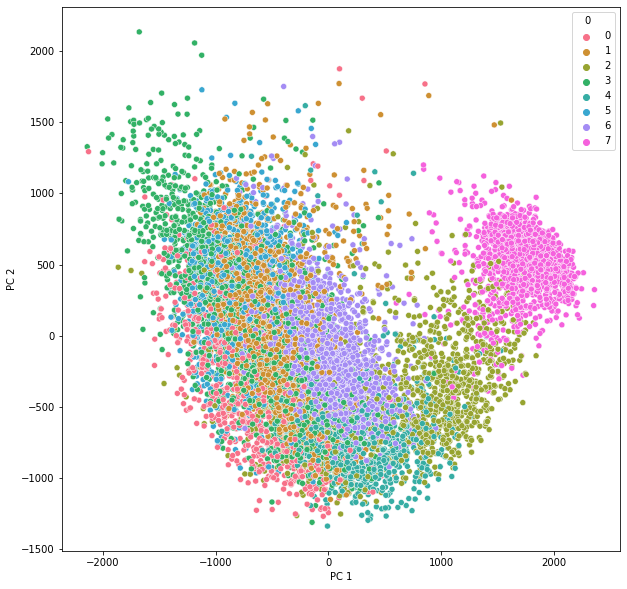

In [22]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = pca_plot_df['PC 1'], y = pca_plot_df['PC 2'], hue = pca_plot_df.iloc[:,2],  palette = sns.color_palette("husl", 8))
plt.show()

### 3D PCA

In [23]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [25]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(x_train)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='PCA: '+f'Total Explained Variance is {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [26]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.28715499 0.09890648 0.05348968]


### 3D t-SNE

In [27]:
import plotly.express as px

tsne_components = manifold.TSNE(n_components=3, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.012s...


C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed neighbors for 11959 samples in 0.730s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 376.124457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.712143
[t-SNE] KL divergence afte

In [28]:
fig = px.scatter_3d(
    tsne_components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='tSNE',
    labels={'0': 'x', '1': 'y', '2': 'z'}
)
fig.show()

In [27]:
import matplotlib.pyplot as plt

In [28]:
x_train=pd.DataFrame(x_train)
x_train.shape

(11959, 2352)

In [29]:
y_train=pd.DataFrame(y_train)
y_train.shape

(11959, 1)

In [30]:
y_train

0
0      7
1      3
2      6
3      6
4      7
...   ..
11954  6
11955  2
11956  1
11957  6
11958  4

[11959 rows x 1 columns]

In [31]:
def get_class_arrays(class_index):
    x = x_train[y_train.iloc[:, 0] == class_index]
    y=y_train[y_train.iloc[:, 0] == class_index]
    return x,y

In [32]:
number_classes=8

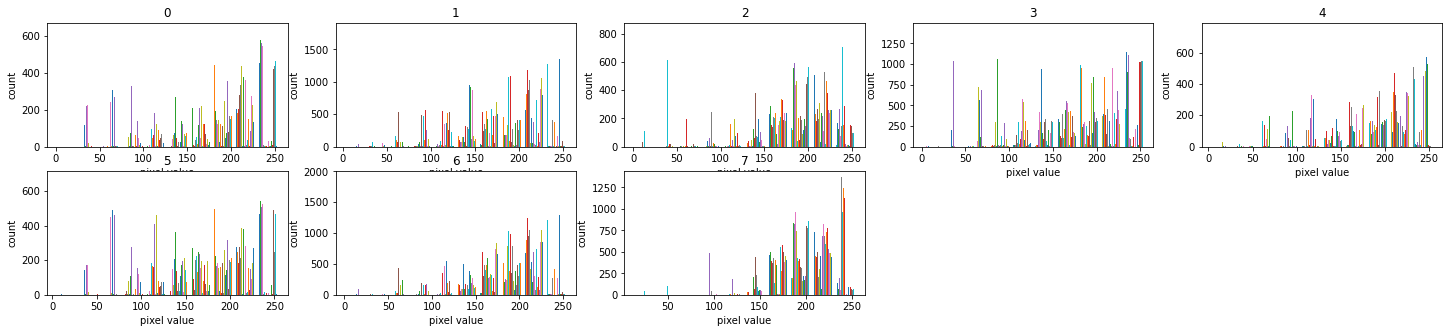

In [33]:
figure = plt.figure(figsize=(25,5))

def get_histogram():
    for i in range(number_classes):
        class_arrayX,class_arrayY = get_class_arrays(i)
        # print(class_arrayX.describe())
        plt.subplot(2,5,i+1)
        _ = plt.hist(class_arrayX)
        plt.title(i)
        plt.xlabel('pixel value')
        plt.ylabel('count')
get_histogram()

(852, 2352)
(2181, 2352)
(1085, 2352)
(2026, 2352)
(849, 2352)
(993, 2352)
(2330, 2352)
(1643, 2352)


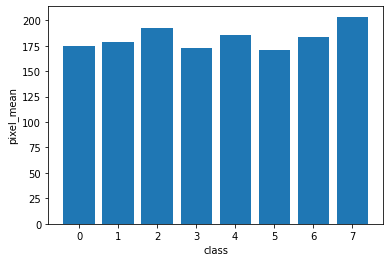

In [34]:
def get_mean_barchart():
    mean_values =[]
    for i in range(number_classes):
        class_arrayX,class_arrayY = get_class_arrays(i)
        print(class_arrayX.shape)
        mean_values.append(class_arrayX.mean(axis=1).mean())
    plt.bar(np.arange(number_classes),mean_values, align='center')
    plt.xticks(np.arange(number_classes))
    plt.xlabel('class')
    plt.ylabel('pixel_mean')

get_mean_barchart()

In [ ]:
embeddings =embeddings =manifold.TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.098s...
[t-SNE] Computed neighbors for 11959 samples in 43.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 385.645257
[t-SNE] KL diverge

UNDERSTAND: https://medium.com/datadl-ai/mnist-exploration-to-execution-25136ca00570

In [ ]:
def get_class_embeddings_arrays(class_index):
    x = embeddings[y_train.iloc[:, 0] == class_index]
    y=y_train[y_train.iloc[:, 0] == class_index]
    return x,y

NameError: name 'get_class_embeddings_arrays' is not defined

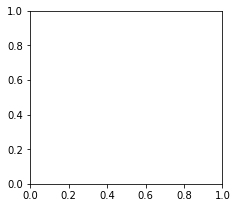

In [5]:
figure = plt.figure(figsize=(20,7))

for i in range(number_classes):
    plt.subplot(2,5,i+1)
    class_embeddings_arrayX,class_embeddings_arrayY = get_class_embeddings_arrays(i)
    plt.scatter(class_embeddings_arrayX[:, 0], class_embeddings_arrayX[:, 1], c=class_embeddings_arrayY, 
                cmap=plt.cm.get_cmap("jet", 10), marker='.')
    plt.clim(-0.5, 9.5)
    plt.axis([-40, 40, -40, 40])
    plt.title(i)